In [4]:
import os
import csv
import SimpleITK as sitk
import six
from radiomics import featureextractor, getTestCase
from radiomics.featureextractor import RadiomicsFeatureExtractor
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt 
import pydicom
from pydicom import dcmread
import dicom2nifti
import pydicom_seg
import io
import tempfile
import gc
import time
import shutil
from dicomweb_client.api import DICOMwebClient
import dicom2nifti.settings as settings

In [5]:
settings. disable_validate_slice_increment()
#pydicom.config.pixel_data_handlers = ['gdcm_handler']

# get the start timen_jobs
st = time.time()
#tmp_dir = os.getenv("SLURM_TMPDIR")                
# Define the float format
float_format = '%.5f'

#path the main directory
main_dir= "/project/166726142/lesee/Synergic-Radiomics"

#path of parameter file which includes the settings for radiomics extraction
params = os.path.join(main_dir,'src/Params_test-harmon.yaml')
auth_token= 'jsQXPhk1MDJDRCMSmVb4No'
header = {'Authorization': 'Bearer ' + auth_token}

#giving the path of web-based dicom files
url="https://platform.paradim.science/api"
client_dcm = DICOMwebClient(url = url, headers = header)
#data =[]

#find the first 'limit' number of studies                                                                   
studies = client_dcm.search_for_studies(limit = 1, get_remaining=False)
#studies = client_dcm.search_for_studies(offset=1290)
studies_dicom = [pydicom.dataset.Dataset.from_json(d) for d in studies]

seg_modality = ['SEG']
header = ['PatientName', 'patientID' 'StudyInstanceUID'] 

data_features =[]
index_annot = []
index_studies =[]
studies_no_seg = []
studies_two_seg = []

In [33]:
for num_std , study_dicom in enumerate(studies_dicom): 
    try: 
        #find the series instance ID from SEG file in each study
        print('Study No. = ', num_std+1 )
        study_instance_uid = study_dicom['StudyInstanceUID'].value
        patient_ID = study_dicom['PatientID'].value
        patient_name = study_dicom['PatientName'].value         
        print('Patient Name = ', patient_name )
        metadata_study = client_dcm.retrieve_study_metadata(study_instance_uid = study_instance_uid)
        modality_values = study_dicom["00080061"]
        # check if there is any segmentation file for this study
        if any('SEG' in modality for modality in modality_values):

            for meta_instance in metadata_study:
    #            print(meta_instance['0008103E'])
    #            if meta_instance['0008103E']['Value'][0]=='Segmentation':
            #Find the SEG (Segmentation) object with the SOP Class UID which is typically '1.2.840.10008.5.1.4.1.1.66.4' for SEG files.            
                if meta_instance['00080016']['Value'][0] == '1.2.840.10008.5.1.4.1.1.66.4':

                    SeriesInstanceUID_seg = meta_instance["00081115"]["Value"][0]['0020000E']['Value'][0]
                else:
                    continue    
            #find the segmentation dicom dataset        
            series = client_dcm.search_for_series(study_instance_uid=study_instance_uid)
            num_seg = 0  
            
            for serie in series:
                series_CT_dicom = pydicom.dataset.Dataset.from_json(serie)
                if series_CT_dicom.Modality in seg_modality:
                    num_seg +=1
                    print(series_CT_dicom.SeriesDescription)                    
                    instances_seg = client_dcm.retrieve_series(study_instance_uid = study_instance_uid,
                        series_instance_uid = series_CT_dicom['SeriesInstanceUID'].value)                    
                    #read the SEG dicom dataset as a sitk image file
                    reader_seg = pydicom_seg.MultiClassReader()
                    result = reader_seg.read(instances_seg[0])
                    img_seg = result.image
                    # Convert SimpleITK segmentation image to NumPy array
                    seg_np = sitk.GetArrayFromImage(img_seg)                    

                    segment_metadata = instances_seg[0].SegmentSequence
                    label_name = []
                    label_number =[] 
                    for segment in segment_metadata:
                        segment_number = segment.SegmentNumber
                        segment_label = segment.SegmentLabel
    #                        segment_description = segment.SegmentDescription
                        label_number.append(segment_number)
                        label_name.append(segment_label)


                #find the references CT series corresponding to the SEG binary image 
                if not series_CT_dicom.Modality in seg_modality:
                    instances = client_dcm.retrieve_series(study_instance_uid = study_instance_uid,
                        series_instance_uid = series_CT_dicom['SeriesInstanceUID'].value)
                    if instances[0][0x0020000e].value == SeriesInstanceUID_seg:
                        print(series_CT_dicom.SeriesDescription)
                        instances_CT = instances
                        #convert the CT dicom images to one nifti file
                        with tempfile.TemporaryDirectory() as tmp_dir:      
                            img_CT = dicom2nifti.convert_dicom.dicom_array_to_nifti(instances_CT,os.path.join(tmp_dir+'_CT.nii'), reorient_nifti=True)["NII"]
                            CT_nifti_path = os.path.join(tmp_dir+'_CT.nii')
                            #read the CT nifit as a sitk image file                             
                            img_CT_stk = sitk.ReadImage(CT_nifti_path)
                            
                            # Convert SimpleITK image to NumPy array
                            img_CT_np = sitk.GetArrayFromImage(img_CT_stk)

                            # Apply HU truncation to a range of -400 HU to 1024 HU for harmonization
                            truncated_image_CT_np = np.clip(img_CT_np, -400, 1024)                            

                            # Convert back to SimpleITK image
                            truncated_image_CT_stk = sitk.GetImageFromArray(truncated_image_CT_np)                              
                            truncated_image_CT_stk.SetSpacing(img_CT_stk.GetSpacing())
                            truncated_image_CT_stk.SetOrigin(img_CT_stk.GetOrigin())
                            truncated_image_CT_stk.SetDirection(img_CT_stk.GetDirection())

                            # Convert SimpleITK image to NumPy array
                            truncated_image_CT_np_2 = sitk.GetArrayFromImage(truncated_image_CT_stk)                            
                            
                            print("original Image =", img_CT_stk)
                            # Debugging prints
                            print("Original Image Shape:", img_CT_stk.GetSize())
                            print("Truncated Image Shape:", truncated_image_CT_stk.GetSize())

                            #Apply HU truncation to a range of -400 HU to 1024 HU for harmonization
#                            truncated_image_CT_stk = np.clip(img_CT_stk, -400, 1024)
                            print("Truncated Image =",truncated_image_CT_stk)
#                            log_filter = sitk.LaplacianRecursiveGaussianImageFilter()
#                            log_filter.SetSigma(1.0)  # desired sigma value
#                            log_filtered_image = log_filter.Execute(truncated_image_CT_stk)

                        #remove the temporary nifti file after reading
                        os.remove(CT_nifti_path)
                        
                        
            # find if the study has more than 1 segmentation file
            if num_seg >1:
                studies_two_seg.append(patient_name)
                print('Patient Name with more than 1 segmentation file = ', patient_name ) 
                continue            
                        

            # Find number of labels (segments)
            N_segments = len(label_name)

            # Find all labels that start with "Tumor"
            tumor_labels = [label for label in label_name if label.startswith("T")]

            # Loop through all the "Tumor" labels and extract radiomics for each tumor
            for tumor_label in tumor_labels:
            # Extract the name after "Tumor"
#                tumor_name = tumor_label[len("Tumor"):]        
                tumor_segment_number = label_number[label_name.index(tumor_label)]     

                # Extract radiomic features
                extractor = featureextractor.RadiomicsFeatureExtractor(params, additionalInfo=True)
                extractor.settings['n_jobs'] = -1
            #   features = extractor.execute(img_CT_stk, img_seg_resampled, label=int(labels_resampled[-1]))
                features = extractor.execute(truncated_image_CT_stk, img_seg, label=int(tumor_segment_number))
                features_key = ['PatientName', 'PatientID', 'StudyInstanceUID' ]
                features_value = [patient_name, patient_ID, study_instance_uid]
                for num , (key, val) in enumerate(six.iteritems(features)):
                    features_key.append(key)
                    features_value.append(val)
                data_features.append(features_value)
                index_studies.append(num_std+1)

        else: 
            studies_no_seg.append(patient_name)
    
            print ("No SEG file for this study =", patient_name)
            continue
        
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")
       
        

Study No. =  1
Patient Name =  BT-10194
Thorax avec ax
original Image = Image (0x8772de0)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 68219
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 68193
  UpdateMTime: 68215
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 155]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 155]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 155]
  Spacing: [0.699219, 0.699219, 2]
  Origin: [-169.65, 34.1504, 1280.4]
  Direction: 
1 0 0
0 -1 0
0 0 1

  IndexToPointMatrix: 
0.699219 0 0
0 -0.699219 0
0 0 2

  PointToIndexMatrix: 
1.43017 0 0
0 -1.43017 0
0 0 0.5

  Inverse Direction: 
1 0 0
0 -1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x107e14c0)
      RTT

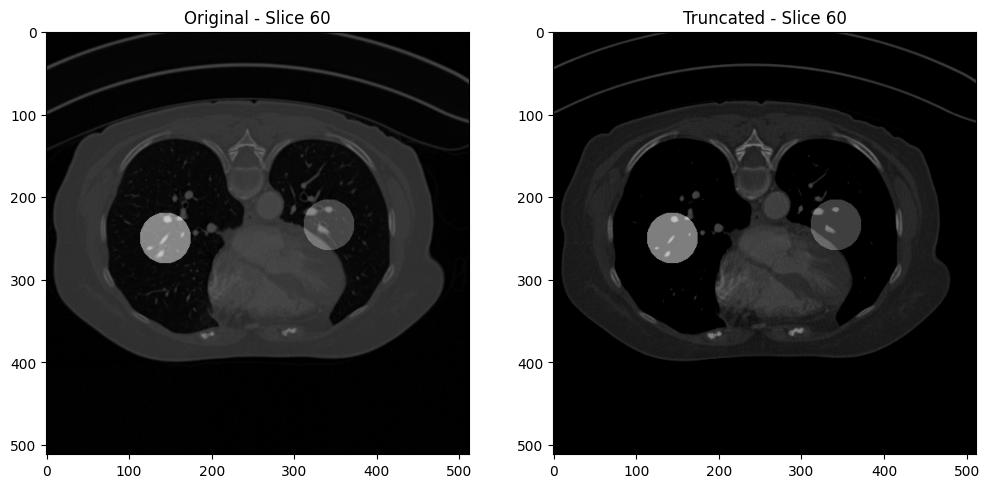

In [60]:
#compare one slice between original and trucated image to make sure about the segmentation

import matplotlib.pyplot as plt

# Assuming img_CT_np and seg_np are 3D NumPy arrays with potentially different numbers of slices
num_slices_ct = img_CT_np.shape[0]
num_slices_trunc_ct = truncated_image_CT_np_2.shape[0]
num_slices_seg = seg_np.shape[0]

# Specify the slice index you want to visualize
selected_slice_index = 35  # Replace with the desired slice index

# Check if the slice index is within the range of both CT and segmentation
plt.figure(figsize=(12, 6))

if selected_slice_index < num_slices_ct and selected_slice_index < num_slices_seg:
    plt.subplot(1, 2, 1)    
    plt.imshow(img_CT_np[selected_slice_index, :, :], cmap='gray', alpha=1.0)
    plt.imshow(seg_np[selected_slice_index, :, :], cmap='gray', alpha=0.5)  # Assuming seg_np is binary
    plt.title(f'Original - Slice {selected_slice_index + 1}')

if selected_slice_index < num_slices_trunc_ct and selected_slice_index < num_slices_seg:
    plt.subplot(1, 2, 2)    
    plt.imshow(truncated_image_CT_np_2[selected_slice_index, :, :], cmap='gray', alpha=1.0)
    plt.imshow(seg_np[selected_slice_index, :, :], cmap='gray', alpha=0.5)  # Assuming seg_np is binary
    plt.title(f'Truncated - Slice {selected_slice_index + 1}')

plt.show()



In [4]:
# write into excel      
writer = pd.ExcelWriter(os.path.join(main_dir,'results/radiomicsfeatures_kheops_SynergiQc_T_test_harmonized.xlsx'), engine='xlsxwriter')

wb  = writer.book
df = pd.DataFrame(data=data_features, index = index_annot, columns=features_key)
df.to_excel(writer, sheet_name="radiomic features")                                     
wb.close()
# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 1193.367344379425 seconds
